In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
# make matplotlib pdf-s text recognizable by evil-Adobe
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

In [4]:
genes_df = pd.read_csv(
    "./gene_annot_data/hg19/geneAnnotationsExonUnions.bed",
    sep="\t",
    header=None,
    names = ["chr",
            "txStart",
            "txEnd",
            "geneName",
            "citationCount",
            "strand",
            "union_geneId", # "refseqId",
            "geneId",
            "geneType",
            "geneDesc",
            "cdsStart",
            "cdsEnd",
            "exonStarts",
            "exonEnds"]
)
genes_df.head()

### we'll be removing duplicated genes because they're likely unamppable and/or harder to deal with anyways ...
### there are of course expections, but will do it anyways:
geneId_grp = genes_df.groupby("geneId")
genes_df = geneId_grp.first()[geneId_grp.size() == 1].reset_index()

### Let's merge in Gene Expression level information into our gene annotation DataFrame 

In [5]:
# alldetected_442NT_442_IAA                     100% 2637KB   5.1MB/s   00:00    
# alldetected_44NT_442IAA                       100% 2578KB   1.6MB/s   00:01    
# alldetected_AAVS1NT_DDX55clonesIAA            100% 3037KB  10.2MB/s   00:00    
# alldetected_AAVS1NT_DDX55clonesNT             100% 3065KB   1.9MB/s   00:01    
# alldetected_AAVS1NT_TAF5LclonesIAA            100% 3044KB  11.0MB/s   00:00    
# alldetected_AAVS1NT_TAF5LclonesNT             100% 3055KB   1.9MB/s   00:01    
# alldetected_siCTRLNT_siDDX55IAA               100% 2558KB  11.0MB/s   00:00    
# alldetected_siCTRLNT_siDDX55NT                100% 2641KB   1.7MB/s   00:01    
# alldetected_siCTRLNT_siTAF5LIAA               100% 2555KB  10.5MB/s   00:00    
# alldetected_siCTRLNT_siTAF5LNT                100% 2601KB  11.0MB/s   00:00    

In [6]:
rsem_df = pd.read_csv("merged_TPM_genes.tsv",sep="\t")[["Id","rsem.out.S442_NT"]]
# genes_Df  overlap   rsem
# ~4_300     ~23_200   ~2_500

In [7]:
genes_exp_df = pd.merge(
    rsem_df,
    genes_df,
    how = 'inner',
    left_on="Id",
    right_on="geneName"
)
print(len(genes_exp_df))
genes_exp_df.head(3)


23225


Id  rsem.out.S442_NT  geneId    chr    txStart      txEnd  geneName  \
0  C9orf152                 0  401546   chr9  112961844  112970439  C9orf152   
1     RPS11              4520    6205  chr19   49999690   50002965     RPS11   
2     ELMO2                14   63916  chr20   44994683   45035690     ELMO2   

   citationCount strand  union_geneId        geneType  \
0              5      -  union_401546  protein-coding   
1            149      +    union_6205  protein-coding   
2             47      -   union_63916  protein-coding   

                              geneDesc   cdsStart     cdsEnd  \
0  chromosome 9 open reading frame 152  112963227  112969859   
1                ribosomal protein S11   49999713   50002892   
2       engulfment and cell motility 2   44995998   45017838   

                                          exonStarts  \
0                                112961844,112969666   
1       49999690,50000450,50000776,50001173,50002768   
2  44994683,44994689,44997529,44999081,44999990,4...   

                                            exonEnds  
0                                112963754,112970439  
1       49999728,50000582,50000852,50001303,50002965  
2  44996199,44996199,44997607,44999164,45000098,4...

### Ad differential expression information here

In [8]:
rdiff_df = pd.read_csv("alldetected_44NT_442IAA")
rdiff_df["log10padj"][rdiff_df["log2FoldChange"]<0] =  -1 * rdiff_df["log10padj"][rdiff_df["log2FoldChange"]<0].values

# # check out how the pvalues look like if there is need
# plt.scatter(rdiff_df["log2FoldChange"],rdiff_df["log10padj"])

In [9]:
genes_exp_df = pd.merge(
    genes_exp_df,
    rdiff_df,
    how = 'left',
    left_on="Id",
    right_on="ID"
)
print(len(genes_exp_df))
genes_exp_df.head(3)

23225


Id  rsem.out.S442_NT  geneId    chr    txStart      txEnd  geneName  \
0  C9orf152                 0  401546   chr9  112961844  112970439  C9orf152   
1     RPS11              4520    6205  chr19   49999690   50002965     RPS11   
2     ELMO2                14   63916  chr20   44994683   45035690     ELMO2   

   citationCount strand  union_geneId  ...        S44_NT      S44_NTR2  \
0              5      -  union_401546  ...           NaN           NaN   
1            149      +    union_6205  ...  17773.383186  25559.022723   
2             47      -   union_63916  ...    473.880760    435.730311   

       S442_IAA    S442_IAAR2      padj log2FoldChange    pvalue      stat  \
0           NaN           NaN       NaN            NaN       NaN       NaN   
1  17718.632086  25943.978977  0.989768       0.010958  0.963229  0.002125   
2    489.117153    449.853841  0.952142       0.045753  0.842046  0.039711   

   foldChange  log10padj  
0         NaN        NaN  
1    1.007624   0.004467  
2    1.032222   0.021298  

[3 rows x 27 columns]

In [10]:
# columns needed for TSS/TTS bed files output:
tx_cols = ["chr", "txStart", "txEnd", "strand", "rsem.out.S442_NT", "log10padj"]

tx_cols_rename = {"chr":"chrom",
                  "txStart":"start",
                  "txEnd":"end",
                  "rsem.out.S442_NT":"exp",
                  "log10padj":"DE"
                 }

gdf =  genes_exp_df[tx_cols].reset_index(drop=True).rename(tx_cols_rename,axis=1)

gdf["size"] = gdf["end"] - gdf["start"]

In [11]:
gdf = gdf.sort_values(["chrom","start"])
gdf = gdf[gdf["chrom"].isin(autosomal_chroms)]
gdf = gdf.reset_index(drop=True)
gdf.head(3)

chrom  start    end strand  exp        DE   size
0  chr1  11873  14409      +    0       NaN   2536
1  chr1  14361  29370      -   32 -0.015968  15009
2  chr1  69090  70008      +    0       NaN    918

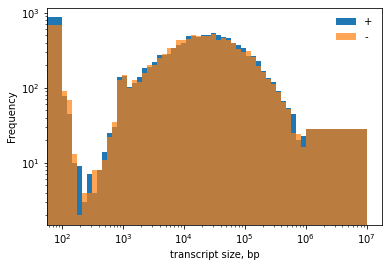

In [12]:
bins = np.r_[0,np.geomspace(100,1_000_000),10_000_000]
gdf[gdf["strand"]=="+"]["size"].plot.hist(bins=bins,log=True,label="+")
gdf[gdf["strand"]=="-"]["size"].plot.hist(bins=bins,log=True,alpha=0.7,label="-")
ax = plt.gca()
ax.set_xscale("log")
ax.set_xlabel("transcript size, bp")
ax.legend(frameon=False)

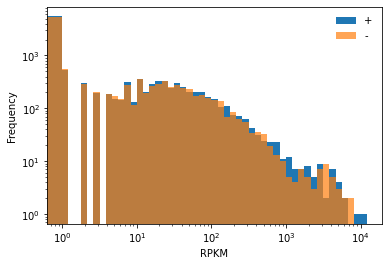

In [13]:
# actually - negative polarity genes are less expressed than tha positive strand genes ...
bins = np.r_[0,np.geomspace(1,12000)]
gdf[gdf["strand"]=="+"]["exp"].plot.hist(bins=bins,log=True,label="+")
gdf[gdf["strand"]=="-"]["exp"].plot.hist(bins=bins,log=True,alpha=0.7,label="-")
ax = plt.gca()
ax.set_xscale("log")
ax.set_xlabel("RPKM")
ax.legend(frameon=False)

In [14]:
exp_bin_edges = [0,.5,5,np.inf]
exp_labels = ("no","low","high")
sizes_bin_edges = [0,50_000,np.inf]
sizes_labels = ("short","long")

gdf["gexp"] = pd.cut(
    gdf["exp"],
    bins = exp_bin_edges,
    labels = exp_labels,
    include_lowest = True
)
gdf["gsize"] = pd.cut(
    gdf["size"],
    bins = sizes_bin_edges,
    labels = sizes_labels,
    include_lowest = True
)
display(gdf.head())
display( gdf.groupby(["gexp","gsize"]).size().unstack(fill_value=0) )

chrom   start     end strand  exp        DE   size  gexp  gsize
0  chr1   11873   14409      +    0       NaN   2536    no  short
1  chr1   14361   29370      -   32 -0.015968  15009  high  short
2  chr1   69090   70008      +    0       NaN    918    no  short
3  chr1  134772  140566      -    0 -0.014134   5794    no  short
4  chr1  562759  564389      -    0       NaN   1630    no  short

gsize  short  long
gexp              
no      8737  2093
low     1819   945
high    5813  2887

In [15]:
# extend the stacking region by the gene length on each side !
gdf["start"] = gdf["start"] - gdf["size"]
gdf["end"] = gdf["end"] + gdf["size"]

In [16]:
def extract_ins(df,
                fname,
                bins=3000,
                flip_by_strand=False,
                flip_sign=False,
                summary = "mean",
               ):
    """
    for a BED-like DF, extract 'signal' from BW (fname) for every interval
    use "strand" information to flip "-" strand genes (or not) ...
    """
    if flip_by_strand:
        return np.asarray([
            bbi.fetch
                   (
                        fname,
                        chrom,
                        start,
                        end,
                        bins=bins,
                        missing=0.0,
                        oob=np.nan,
                        summary=summary,
                    )[:: (-1 if strand=="-" else 1) ] * (-1 if ( (strand=="-") and (flip_sign) ) else 1 )
            # flip in place for "-" genes and multiply by -1 if requested ...
          for chrom, start, end, strand, *_ in df.itertuples(index=False)
        ])
    else:
        return np.asarray([
            bbi.fetch
                   (
                        fname,
                        chrom,
                        start,
                        end,
                        bins=bins,
                        missing=0.0,
                        oob=np.nan,
                        summary=summary,
                    )
          for chrom, start, end, *_ in df.itertuples(index=False)
        ])


### TSS to TTS scaled profiles ...

In [17]:
# # samples.keys()
# [k for k in samples.keys() if (not(k.startswith("ins")) and not(k.startswith("ev1")) )] 

In [18]:
# # samples.keys()
# [k for k in samples.keys() if not k.startswith("ins")]

In [19]:
# [k for k in samples.keys() if k.startswith("ins")]

In [20]:
# key features/signals that we want to extract for our genes ...
key_features = [ 
                'ins_CTCF',
                'ins_noCTCF',
#                  'ins_mutCtr_CTCF',
#                  'ins_mutCtr_noCTCF',
#                  'ins_mutDDX_CTCF',
#                  'ins_mutDDX_noCTCF',
                "ctcf",
                "polII",
#                 "noctcf",
                'ddx_CTCF',
                'ddx_noCTCF',
                "Rloop_K562",
                'rad21_CTCF',
                'h3k27ac_r1',
#                 'h3k4_r1',
#                 'G4a_r2',
#      'dnase-hap1',
                'mrna_ctcf',
               ]

#                 "Rloop_K562",
#                 'rad21_CTCF',
#                 'rad21_noCTCF',

### Extracting Meta-gene profiles of the key-features (insulations, Chip_Seq data etc)

#### Here we extract data for + and - genes separately and flip "-" genes to orient them same way as the "+" genes ...
#### using `extract_ins` function...

In [21]:
profiles_dict = {}

# group genes by expression and size before extracting corresponding profiles of a list of features :
gene_groups = gdf.groupby(["gexp","gsize"])
for feature_name in key_features:
    print(f"extracting {feature_name} for the genes ...")
    feature_fname = samples[feature_name]["fname"]
    profiles_dict[feature_name] = gene_groups.apply(
                                    lambda sub_df: extract_ins(
                                        sub_df,
                                        feature_fname,
                                        bins=3000,
                                        flip_by_strand=True,
                                    )
                                )

extracting ins_CTCF for the genes ...
extracting ins_noCTCF for the genes ...
extracting ctcf for the genes ...
extracting polII for the genes ...
extracting ddx_CTCF for the genes ...
extracting ddx_noCTCF for the genes ...
extracting Rloop_K562 for the genes ...
extracting rad21_CTCF for the genes ...
extracting h3k27ac_r1 for the genes ...
extracting mrna_ctcf for the genes ...


In [22]:
# gene_groups.groups.keys()

In [23]:
# # LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...

# _tmp_profiles_dict = {}
# for feature_name in ['CTCF_motif_plus', 'CTCF_motif_minus']:
#     print(f"extracting {feature_name} for the genes ...")
#     feature_fname = feature_name+".bb"
#     _tmp_profiles_dict[feature_name] = gene_groups.apply(
#                                     lambda sub_df: extract_ins(
#                                         sub_df,
#                                         feature_fname,
#                                         bins=3000,
#                                         flip_by_strand=True,
#                                         flip_sign=True,
#                                         summary="mean"
#                                     )
#                                 )

# if key_features[-1] == "CTCF_motif":
#     key_features.pop()
# feat_name = "CTCF_motif"
# key_features.append("CTCF_motif")

# profiles_dict["CTCF_motif"] = {}
# for key in gene_groups.groups.keys():
#     profiles_dict["CTCF_motif"][key] = _tmp_profiles_dict["CTCF_motif_plus"][key] \
#                                     - _tmp_profiles_dict["CTCF_motif_minus"][key]

In [24]:
# SpliceDDX55aux.bb
# SpliceCTCFaux.bb

In [25]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...
feat_name = "SpliceDDX"

_tmp_profiles_dict = {}
for feature_name in ['SpliceDDX55aux']:
    print(f"extracting {feature_name} for the genes ...")
    feature_fname = feature_name+".bb"
    _tmp_profiles_dict[feature_name] = gene_groups.apply(
                                    lambda sub_df: extract_ins(
                                        sub_df,
                                        feature_fname,
                                        bins=3000,
                                        flip_by_strand=True,
                                        flip_sign=False,
                                        summary="mean"
                                    )
                                )

if key_features[-1] == feat_name:
    key_features.pop()
key_features.append(feat_name)

profiles_dict[feat_name] = {}
for key in gene_groups.groups.keys():
    profiles_dict[feat_name][key] = _tmp_profiles_dict["SpliceDDX55aux"][key]

extracting SpliceDDX55aux for the genes ...


In [26]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...
feat_name = "SpliceCTCF"

_tmp_profiles_dict = {}
for feature_name in ['SpliceCTCFaux']:
    print(f"extracting {feature_name} for the genes ...")
    feature_fname = feature_name+".bb"
    _tmp_profiles_dict[feature_name] = gene_groups.apply(
                                    lambda sub_df: extract_ins(
                                        sub_df,
                                        feature_fname,
                                        bins=3000,
                                        flip_by_strand=True,
                                        flip_sign=False,
                                        summary="mean"
                                    )
                                )

if key_features[-1] == feat_name:
    key_features.pop()
key_features.append(feat_name)

profiles_dict[feat_name] = {}
for key in gene_groups.groups.keys():
    profiles_dict[feat_name][key] = _tmp_profiles_dict["SpliceCTCFaux"][key]

extracting SpliceCTCFaux for the genes ...


In [27]:
# # LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...
# feat_name = "K562_enhance"

# _tmp_profiles_dict = {}
# for feature_name in ['K562_Enhancers']:
#     print(f"extracting {feature_name} for the genes ...")
#     feature_fname = feature_name+".bb"
#     _tmp_profiles_dict[feature_name] = gene_groups.apply(
#                                     lambda sub_df: extract_ins(
#                                         sub_df,
#                                         feature_fname,
#                                         bins=3000,
#                                         flip_by_strand=True,
#                                         flip_sign=False,
#                                         summary="mean"
#                                     )
#                                 )

# if key_features[-1] == feat_name:
#     key_features.pop()
# key_features.append(feat_name)

# profiles_dict[feat_name] = {}
# for key in gene_groups.groups.keys():
#     profiles_dict[feat_name][key] = _tmp_profiles_dict["K562_Enhancers"][key]

In [28]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...

_tmp_profiles_dict = {}
for feature_name in ['CTCF_peaks_plus', 'CTCF_peaks_minus']:
    print(f"extracting {feature_name} for the genes ...")
    feature_fname = feature_name+".bb"
    _tmp_profiles_dict[feature_name] = gene_groups.apply(
                                    lambda sub_df: extract_ins(
                                        sub_df,
                                        feature_fname,
                                        bins=3000,
                                        flip_by_strand=True,
                                        flip_sign=True,
                                        summary="mean"
                                    )
                                )

if key_features[-1] == "CTCF_peaks":
    key_features.pop()
feat_name = "CTCF_peaks"
key_features.append("CTCF_peaks")

profiles_dict["CTCF_peaks"] = {}
for key in gene_groups.groups.keys():
    profiles_dict["CTCF_peaks"][key] = _tmp_profiles_dict["CTCF_peaks_plus"][key] \
                                    - _tmp_profiles_dict["CTCF_peaks_minus"][key]

extracting CTCF_peaks_plus for the genes ...
extracting CTCF_peaks_minus for the genes ...


In [29]:
del _tmp_profiles_dict

# fill out some odf the categories with blanks - to save memory ...
for k in profiles_dict:
    profiles_dict[k][("low","short")] = np.nan
    profiles_dict[k][("low","long")] = np.nan
    profiles_dict[k][("no","short")] = np.nan
    profiles_dict[k][("high","short")] = np.nan

In [30]:
# # quantify ctcf peaks ?!
# # gene_groups.groups.keys()
# stackup_for_sorting = profiles_dict["CTCF_peaks"][("no","long")]
# length,width = stackup_for_sorting.shape
# TSS_bin = int(width/3)
# TTS_bin = int(2*width/3)

# upstream = np.nanmean(stackup_for_sorting[:,TSS_bin-3:TSS_bin+3],axis=1)
# downstream = np.nanmean(stackup_for_sorting[:,TTS_bin-5:TTS_bin+500],axis=1)
# plt.scatter(upstream,downstream,alpha=0.1)

### introduce categories of interest here `[("high","long"), ("no","long")]` ...

In [31]:
exp_size_cats = [("high","long"), ("no","long")]

In [32]:
profiles_dict.keys()

dict_keys(['ins_CTCF', 'ins_noCTCF', 'ctcf', 'polII', 'ddx_CTCF', 'ddx_noCTCF', 'Rloop_K562', 'rad21_CTCF', 'h3k27ac_r1', 'mrna_ctcf', 'SpliceDDX', 'SpliceCTCF', 'CTCF_peaks'])

In [33]:
insulation_keys = [k for k in key_features if k.startswith("ins")]
for ins_feature in insulation_keys:
#     profiles_dict[ins_feature] = profiles_dict[ins_feature].to_dict()
    for key, ins_stack in profiles_dict[ins_feature].items():
        if key in exp_size_cats:
            l,w = ins_stack.shape
            flank_size = int(w*0.25)
            # get shoulders of the stack
            shoulder_idxs = np.r_[:flank_size,w-flank_size:w]
            profiles_dict[ins_feature][key] = ins_stack - \
                np.nanmean(
                    ins_stack[:,shoulder_idxs],
                    axis=1,
                    keepdims=True
                )


In [47]:
# NOW REORDER A STACKUPS FOR EACH FEATURE ACCORDING TO SOMETHING ....
reordered_jdxs = OrderedDict()
for feature_key in exp_size_cats:
    stackup_for_sorting = profiles_dict["SpliceDDX"][feature_key]
#     stackup_for_sorting = profiles_dict["CTCF_peaks"][feature_key]
    # for a given set of stackups for a given list of features ...
    length,width = stackup_for_sorting.shape
    TSS_bin = int(width/3)
    TTS_bin = int(2*width/3)

    tmp_stack = {}
#     tmp_stack['ctcf_mean'] = np.nanmean(stackup_for_sorting[:,:TSS_bin-2],axis=1) \
#             - np.nanmean(stackup_for_sorting[:,TTS_bin-10:TTS_bin+20],axis=1)
#     tmp_stack['ctcf_mean'] = np.nanmean(stackup_for_sorting[:,TSS_bin:TTS_bin],axis=1)
    tmp_stack['splice_mean'] = np.nanmean(stackup_for_sorting[:,TSS_bin:TTS_bin],axis=1)
    
    _, _jjj = recursive_data_ordering(
        ks = [('splice_mean', "sort", 1, False)],
        idxs = np.arange( length ),
        data_dict = tmp_stack,
        verbose=True
    )
    reordered_jdxs[feature_key] = _jjj
    
#     print((tmp_stack['splice_mean']> 0).sum())
#     nonzero_splice = (tmp_stack['splice_mean']> 0).sum()
#     ######
#     # extracxt genes with signif splicing events here ...
#     #####
#     # gene_groups - groupby gdf
#     gdf_sync = genes_exp_df.reset_index(drop=True)
#     gdf_sync = gdf_sync.sort_values(["chr","txStart"])
#     gdf_sync = gdf_sync[gdf_sync["chr"].isin(autosomal_chroms)]
#     gdf_sync = gdf_sync.reset_index(drop=True)
#     gdf_sync.head(3)
#     # trying to sync pristine gene annotation with `gdf` ...
#     idx = gene_groups.get_group(feature_key).index
# #     print(gdf_sync.loc[idx,"chr"].reset_index(drop=True).loc[_jjj[:nonzero_splice]].unique())
#     # take those with the most splicing ...
# #     print(gdf_sync.loc[idx].reset_index(drop=True).loc[_jjj[:nonzero_splice]])
#     if feature_key == ("high","long"):
#         gdf_sync.loc[idx].reset_index(drop=True).loc[_jjj[:nonzero_splice]][["chr","txStart","txEnd","strand","geneName"]].to_csv("GeneAnnot-SignifSplicers-AAVS1NTtoDDX55sg2BNT.tsv",index=False,sep="\t",header=None)
# #     print(gdf_sync.loc[idx,"chr"].unique())

# ! scp GeneAnnot-SignifSplicers-AAVS1NTtoDDX55sg2BNT.tsv ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# ! scp GeneAnnot-366SignifSplicers-44NTto442IAA.tsv ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

sorting 2887 elements of splice_mean into 1 groups ...
547
sorting 2093 elements of splice_mean into 1 groups ...
23


In [35]:
titles = key_features

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
for s in key_features:
    if s.startswith("CTCF_"):
        bw_fnames[s] = "blah"
        binsizes[s] = 1
        flanks[s] = 1
        limss[s] = (-0.2,0.2)
        cmps[s] = "coolwarm"
        norms[s] = None
    elif s.startswith("Splice"):
        bw_fnames[s] = "blah"
        binsizes[s] = 1
        flanks[s] = 1
        limss[s] = (0,0.01)
        cmps[s] = "Blues"
        norms[s] = None
    elif s.startswith("K562"):
        bw_fnames[s] = "blah"
        binsizes[s] = 1
        flanks[s] = 1
        limss[s] = (0,0.5)
        cmps[s] = "Blues"
        norms[s] = None
    else:
        bw_fnames[s] = samples[s]["fname"]
        binsizes[s] = samples[s]["binsize"]
        flanks[s] = samples[s]["flank"]
        limss[s] = samples[s]["crange"]
        cmps[s] = samples[s]["cmap"]
        norms[s] = samples[s]["norm"]
    
# ADJUST COLOMAP FOR INSULATION AND ADJUST VMIN/VMAX FOR THE INSULATION AS WELL ....
# insulation
for s in insulation_keys:
    limss[s] = (-.15,.1)
    cmps[s] = cmapYlGnBu_r

limss["ctcf"] = (0,0.6)
limss["noctcf"] = (0,0.6)
limss["Rloop_K562"] = (0,5)
limss['rad21_CTCF'] = (0,.3)
limss['h3k27ac_r1'] = (0,.1)
limss['G4a_r2'] = (0,20)
limss['ddx_CTCF'] = (0,.15)
limss['ddx_noCTCF'] = (0,.15)
# limss["mrna_ctcf"] = (0,5) # use matplotlib.colors.LogNorm(vmin=1.,vmax=20.)
# limss['rad21_noCTCF'] = (0,.3)



hmss = OrderedDict()

for feature_key in exp_size_cats:
    jjj = reordered_jdxs[feature_key]
#     hmss[feature_key] = [ profiles_dict[_k][feature_key] for _k in key_features ]
    hmss[feature_key] = [ profiles_dict[_k][feature_key][jjj] for _k in key_features ]

_limss = [ limss[_k] for _k in key_features ]
_cmps = [ cmps[_k] for _k in key_features ]
_binsizes = [ binsizes[_k] for _k in key_features ]
_norms = [ norms[_k] for _k in key_features ]


In [36]:
# # plotting expression size along the new sorting order ...
# np.log(gene_groups.get_group(("high","long")).reset_index(drop=True).loc[reordered_jdxs[("high","long")]]["exp"]).plot()

#### Plotting the profiles ...

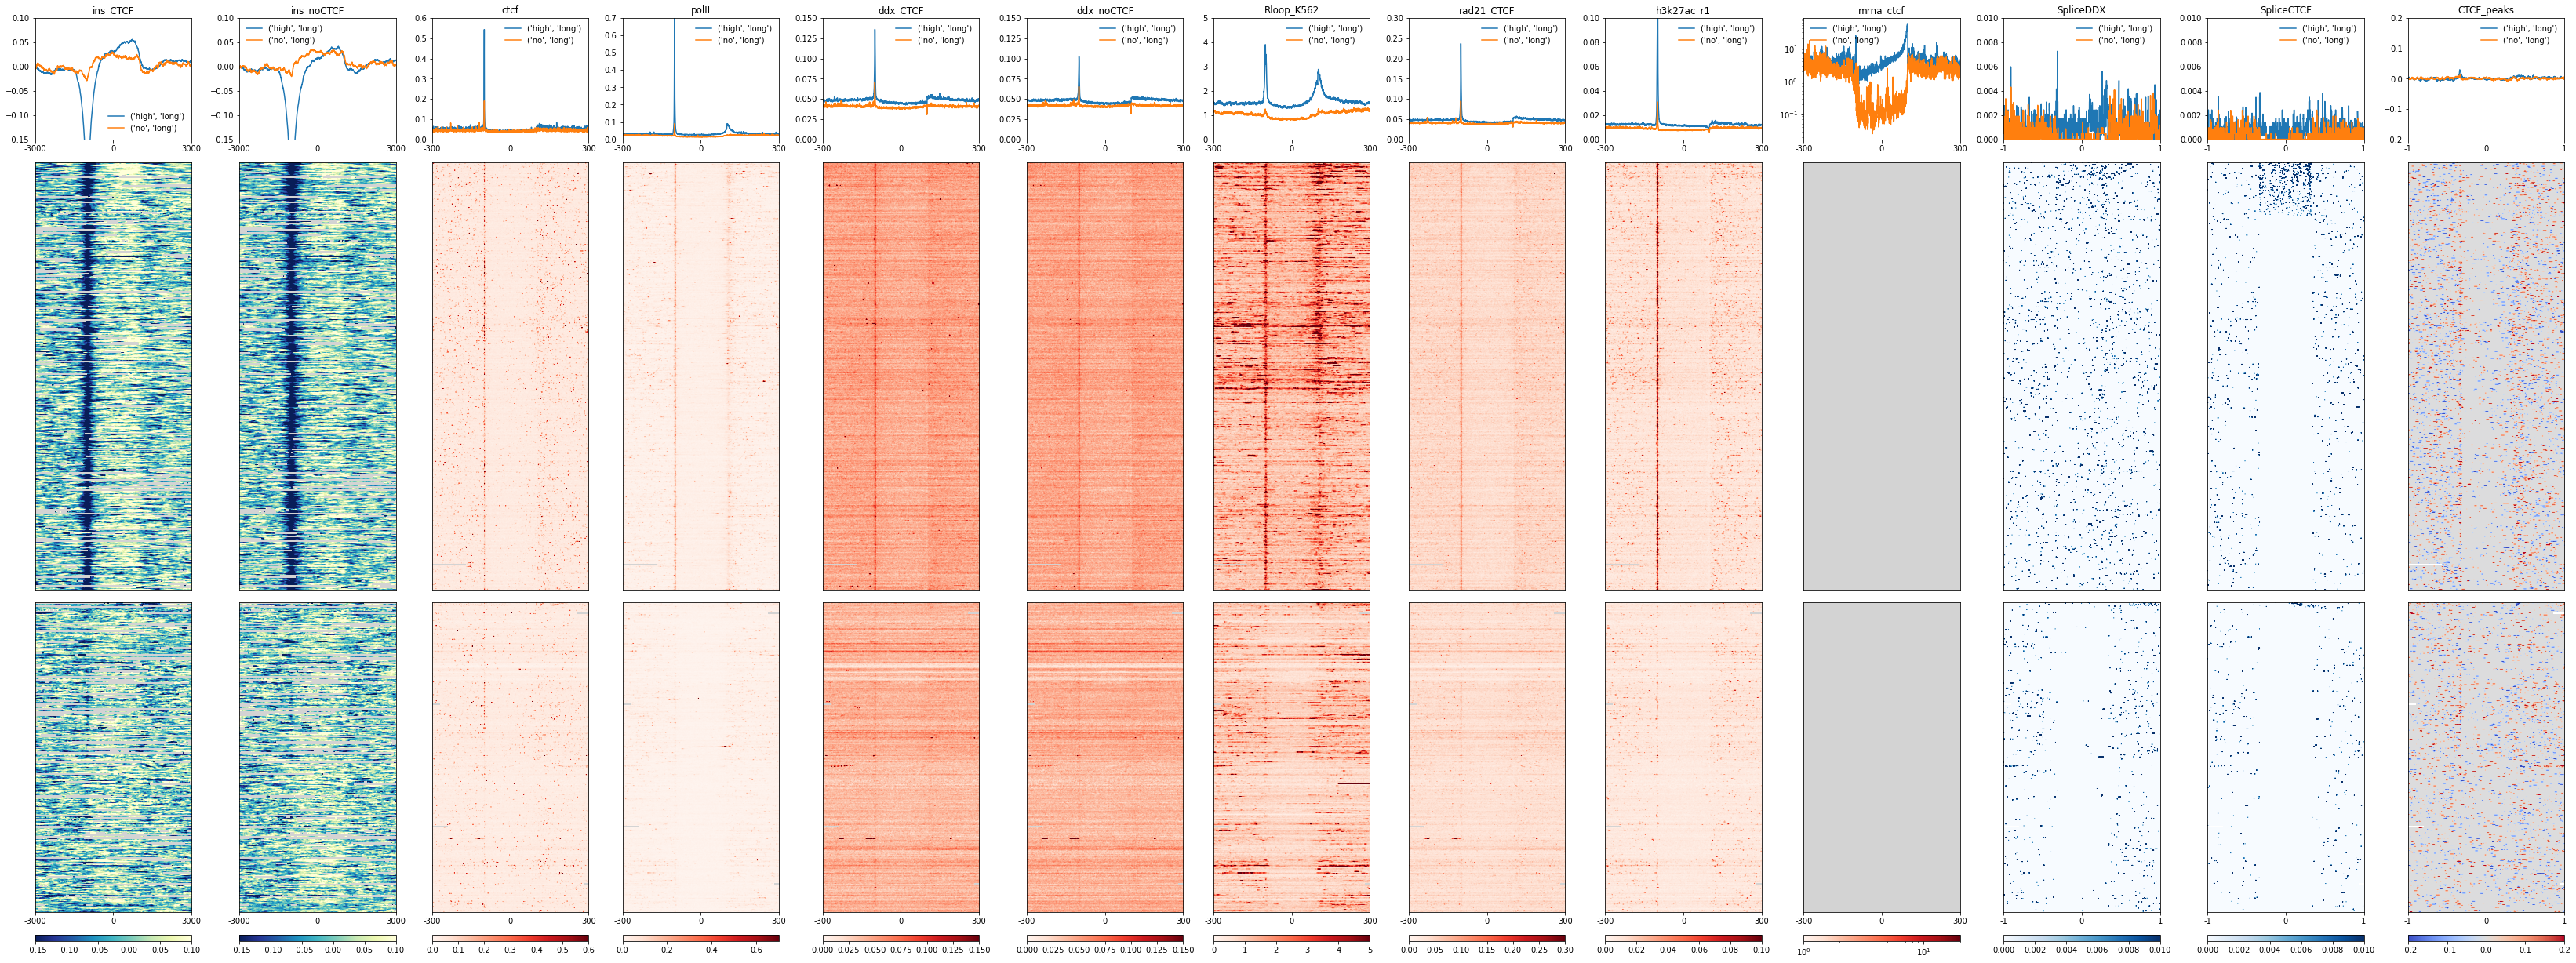

In [39]:
# ordered by the gene size ...
plot_sss( hmss = hmss,
          titles = titles,
          limss = _limss,
          cmps = _cmps,
          norms=_norms,
          binsizes=_binsizes,
          labels=None,
          fillmissing=False,
          interpolation="bilinear",
          inch_per_1k_stack = 2.9,
         )

In [126]:
rrrrTSS = np.nanmean(profiles_dict["CTCF_peaks"][("high","long")][jjj,:TSS_bin], axis=1)
uuuuTSS = np.count_nonzero(profiles_dict["CTCF_peaks"][("high","long")][jjj,:TSS_bin], axis=1)

rrrrTTS = np.nanmean(profiles_dict["CTCF_peaks"][("high","long")][jjj,:TTS_bin], axis=1)
uuuuTTS = np.count_nonzero(profiles_dict["CTCF_peaks"][("high","long")][jjj,:TTS_bin], axis=1)


rrrr1D = np.nanmean(profiles_dict["CTCF_peaks"][("high","long")][jjj,TSS_bin:TTS_bin], axis=1)
uuuu1D = np.count_nonzero(profiles_dict["CTCF_peaks"][("high","long")][jjj,TSS_bin:TTS_bin], axis=1)


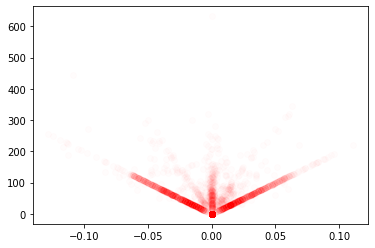

In [134]:
plt.plot(rrrrTTS,uuuuTTS,"ro",alpha=0.01)

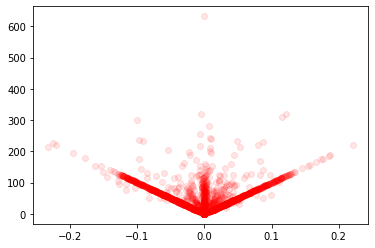

In [131]:
plt.plot(rrrrTSS,uuuuTSS,"ro",alpha=0.1)

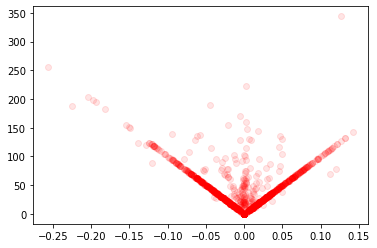

In [132]:
plt.plot(rrrr1D,uuuu1D,"ro",alpha=0.1)

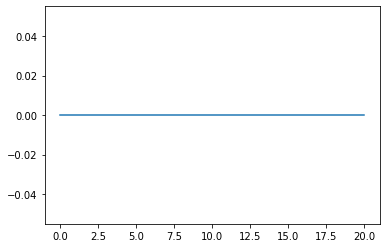

In [54]:
# plt.plot(tmp_stack['splice_mean'][jjj[39:60]])
# jjj = reordered_jdxs[feature_key]

In [42]:
# gene_groups.get_group(("high","long")).reset_index(drop=True).loc[jjj]


# gene_groups - groupby gdf
gdf_sync = genes_exp_df.reset_index(drop=True)
gdf_sync = gdf_sync.sort_values(["chr","txStart"])
gdf_sync = gdf_sync[gdf_sync["chr"].isin(autosomal_chroms)]
gdf_sync = gdf_sync.reset_index(drop=True)
gdf_sync.head(3)

Id  rsem.out.S442_NT     geneId   chr  txStart  txEnd geneName  \
0  DDX11L1                 0  100287102  chr1    11873  14409  DDX11L1   
1   WASH7P                32     653635  chr1    14361  29370   WASH7P   
2    OR4F5                 0      79501  chr1    69090  70008    OR4F5   

   citationCount strand     union_geneId  ...      S44_NT    S44_NTR2  \
0              2      +  union_100287102  ...         NaN         NaN   
1              4      -     union_653635  ...  515.749742  730.734326   
2              3      +      union_79501  ...         NaN         NaN   

     S442_IAA  S442_IAAR2      padj log2FoldChange    pvalue      stat  \
0         NaN         NaN       NaN            NaN       NaN       NaN   
1  477.494568  733.591929  0.963901      -0.041499  0.878494  0.023372   
2         NaN         NaN       NaN            NaN       NaN       NaN   

   foldChange  log10padj  
0         NaN        NaN  
1    0.971645  -0.015968  
2         NaN        NaN  

[3 rows x 27 columns]

In [44]:
gene_groups.get_group(("high","long")).reset_index(drop=True).loc[jjj]


chrom      start        end strand  exp        DE    size  gexp gsize
381   chr10   96028505   96429881      +    7  0.131012  133792  high  long
74     chr1   47651052   47845326      -   27 -0.036092   64758  high  long
1470   chr2  112408662  112758324      -   80  0.666728  116554  high  long
345   chr10   71975044   72226087      -    9 -0.305237   83681  high  long
1727  chr22   29105642   29627393      +   16  0.199339  173917  high  long
...     ...        ...        ...    ...  ...       ...     ...   ...   ...
1389   chr2   37268514   37442028      -   15  0.368205   57838  high  long
1390   chr2   37403314   37626307      -   34  0.302564   74331  high  long
1391   chr2   38436464   38690357      -   59  0.302309   84631  high  long
1392   chr2   38824603   39030559      +   11  0.397687   68652  high  long
0      chr1    1485435    1740936      -   52 -0.092656   85167  high  long

[2093 rows x 9 columns]

In [112]:
jjj = reordered_jdxs[("high","long")]
rrrr1D = np.nanmean(profiles_dict["CTCF_peaks"][("high","long")][jjj,TSS_bin:TTS_bin], axis=1)
y = gene_groups.get_group(("high","long")).reset_index(drop=True).loc[jjj,"size"].values

# ccccc = 600
# xx1 = np.nanmean(rrrr[:ccccc],axis=0)



# yy1 = np.nanmean(rrrr[-ccccc:],axis=0)

# plt.plot(xx1,"b-",label=f"{np.nanmean(y[:ccccc])}")
# plt.plot(yy1,"r-",label=f"{np.nanmean(y[-ccccc:])}")
# plt.legend()

In [111]:
# rrrr.shape
# plt.plot(rrrr)
# pd.Series(y).rolling(window=20).mean().plot()

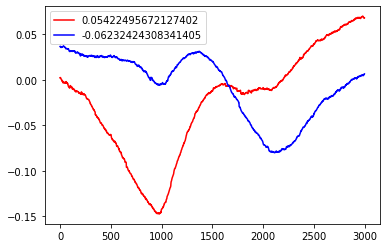

In [119]:
rrrr = profiles_dict["ins_CTCF"][("high","long")][jjj]
# y = gene_groups.get_group(("high","long")).sort_values(by="DE")["DE"].values
ccccc = 300
xx1 = np.nanmean(rrrr[:ccccc],axis=0)
yy1 = np.nanmean(rrrr[-ccccc:],axis=0)

plt.plot(xx1,"r-",label=f"{np.nanmean(rrrr1D[:ccccc])}")
plt.plot(yy1,"b-",label=f"{np.nanmean(rrrr1D[-ccccc:])}")
plt.legend()

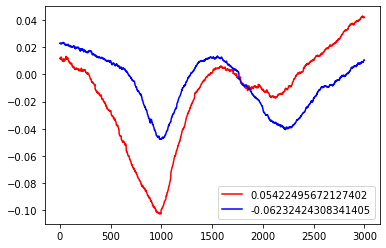

In [120]:
rrrr = profiles_dict["ins_noCTCF"][("high","long")][jjj]
# y = gene_groups.get_group(("high","long")).sort_values(by="DE")["DE"].values
ccccc = 300
xx1 = np.nanmean(rrrr[:ccccc],axis=0)
yy1 = np.nanmean(rrrr[-ccccc:],axis=0)

plt.plot(xx1,"r-",label=f"{np.nanmean(rrrr1D[:ccccc])}")
plt.plot(yy1,"b-",label=f"{np.nanmean(rrrr1D[-ccccc:])}")
plt.legend()

In [31]:
# x = np.nanmean(profiles_dict["ctcf"][("high","long")][:,998:1003],axis=1)
# y = gene_groups.get_group(("high","long")).sort_values(by="DE")["DE"].values

In [38]:
def plot_sss(
          hmss, # will become a dictionary now (or list) ...
          titles,
          limss,
          cmps,
          norms=None,
          binsizes=None,
          labels=None,
          fillmissing=False,
          interpolation="nearest",
          inch_per_1k_stack= 1.2, #inches per 1000 elements stackup ...
         ):
    # rewrite everyhting assuming hmss is a dict of stackup groups !
    # groups are plotted on top of each other ...
    
    # regardless - claculate number of axes for stackups ...
    num_stackup_groups = len(hmss)
    # pick in every stackup group and see how many are there
    num_stackups = max(len(hmss[k]) for k in hmss)
    num_rows = num_stackups
    # let's figure out - how tall is this stackup
    # get heights of stackups from each groups
    stackup_group_heights = [len(hmss[k][0]) for k in hmss]
    stackup_height = sum(stackup_group_heights)*inch_per_1k_stack/1_000
    figure_height = stackup_height + 2.5
    fig = plt.figure(
        figsize=(3.5*num_rows, figure_height),
        facecolor="white",
        constrained_layout=True
    )
    gs = fig.add_gridspec(
        num_stackup_groups+2,
        num_rows,
        width_ratios=[1]*num_rows,
        height_ratios = \
            [0.95*2.5/figure_height] + \
            [(_h/sum(stackup_group_heights))*(figure_height-2.5)/figure_height for _h in stackup_group_heights] + \
            [0.05*2.5/figure_height]
    )

    ax_profile = {}
    ax_stackup = {}
    ax_cbar = {}
    hmss_order = list( range(num_rows) )
    # replace following with the pre-defined column indexes ...
    for idx in hmss_order:
        ax_profile[idx] = fig.add_subplot(gs[0,idx])
        ax_stackup[idx] = [fig.add_subplot(gs[_i+1,idx]) for _i in range(num_stackup_groups)] # stackup groups ...
        ax_cbar[idx] = fig.add_subplot(gs[-1,idx])

    hm_arr = {}
    profile_hm = {}
    labels_dict = {}
    # for each group of stackups (vertically set)
    for group_id, k in enumerate(hmss):
        hm_arr[group_id] = {}
        profile_hm[group_id] = {}
        labels_dict[group_id] = {}
        # for every stackup in each group (horizontal set)
        for idx, hm in zip(hmss_order, hmss[k]):
            if fillmissing:
                X = hm[:]
                missing = ~np.isfinite(X)
                mu = np.nanmean(X, axis=0, keepdims=True) # axis 0 or 1 - rows or columns ?!
                hm_arr[group_id][idx] = np.where(missing, mu, X)
            else:
                hm_arr[group_id][idx] = hm[:]
            profile_hm[group_id][idx] = np.nanmean(hm_arr[group_id][idx],axis=0)
            labels_dict[group_id][idx] = k
    
    # turning some of the input parameters into "oredered" or labeled dicts ...
    if norms is None:
        norms = { _i:None for _i in hmss_order}
    else:
        norms = { _i:norms[i] for i,_i in enumerate(hmss_order)}
    vlims = { _i:limss[i] for i,_i in enumerate(hmss_order)}
    titles = { _i:titles[i] for i,_i in enumerate(hmss_order)}
    if binsizes is None:
        binsizes = { _i:1 for _i in hmss_order}
    else:
        binsizes = { _i:binsizes[i] for i,_i in enumerate(hmss_order)}

    for idx, cmap in zip(hmss_order, cmps):
        # plot profiles from every group on a single common axis for profiles...
        for _i in range(num_stackup_groups):
            ax_profile[idx].plot(profile_hm[_i][idx], label=labels_dict[_i][idx])
        ax_profile[idx].set_yscale("linear" if norms[idx] is None else "log")
        ax_profile[idx].legend(frameon=False)
        # stackups for every group ...
        for _i in range(num_stackup_groups):
            stack_hm = ax_stackup[idx][_i].imshow(
                              hm_arr[_i][idx],
                              norm=norms[idx],
                              aspect="auto",
                              vmin=vlims[idx][0],
                              vmax=vlims[idx][1],
                              cmap=cmap,
                              interpolation=interpolation,
            )
        # beautify ...
        group_id_beautify = 0
        first_bin = 0-.5
        center_bin = hm_arr[group_id_beautify][idx].shape[1]/2 - .5
        last_bin = hm_arr[group_id_beautify][idx].shape[1]-.5
        ax_profile[idx].set_xlim([first_bin, last_bin])
        ax_profile[idx].set_ylim(vlims[idx])
        ax_profile[idx].set_title(titles[idx])
        # human readable kb stuff:
        flank_in_kb = int((center_bin+.5)*binsizes[idx]/1000)
        flank_ticks = [first_bin, center_bin, last_bin]
        flank_ticklabels = [-flank_in_kb, 0, flank_in_kb]
        ax_profile[idx].set_xticks(flank_ticks)
        ax_profile[idx].set_xticklabels(flank_ticklabels)
        for _i in range(num_stackup_groups-1):
            ax_stackup[idx][_i].set_xticks([])
            ax_stackup[idx][_i].set_xticklabels([])
            ax_stackup[idx][_i].set_yticks([])
            ax_stackup[idx][_i].set_yticklabels([])
        # bottom one - show ticks for now ...
        _i = num_stackup_groups-1
        ax_stackup[idx][_i].set_xticks(flank_ticks)
        ax_stackup[idx][_i].set_xticklabels(flank_ticklabels)
        ax_stackup[idx][_i].set_yticks([])
        ax_stackup[idx][_i].set_yticklabels([])
        plt.colorbar(stack_hm,cax=ax_cbar[idx],orientation="horizontal")
        
    return None


#### Plotting the profiles ...

In [ ]:
# ordered by the gene size ...
plot_sss( hmss = {"1":[pgene_profiles[("no","medium")]],
                  "2":[pgene_profiles[("low","medium")]],
                  "3":[pgene_profiles[("med","medium")]],
                  "4":[pgene_profiles[("high","medium")]],
                 },
          titles = ["yyy"],
          limss = [(.5,6)],
          cmps = ["YlGnBu_r"],
          norms=None,
          binsizes=None,
          labels=None,
          fillmissing=True,
          interpolation="bilinear",
          inch_per_1k_stack = 1.9,
         )

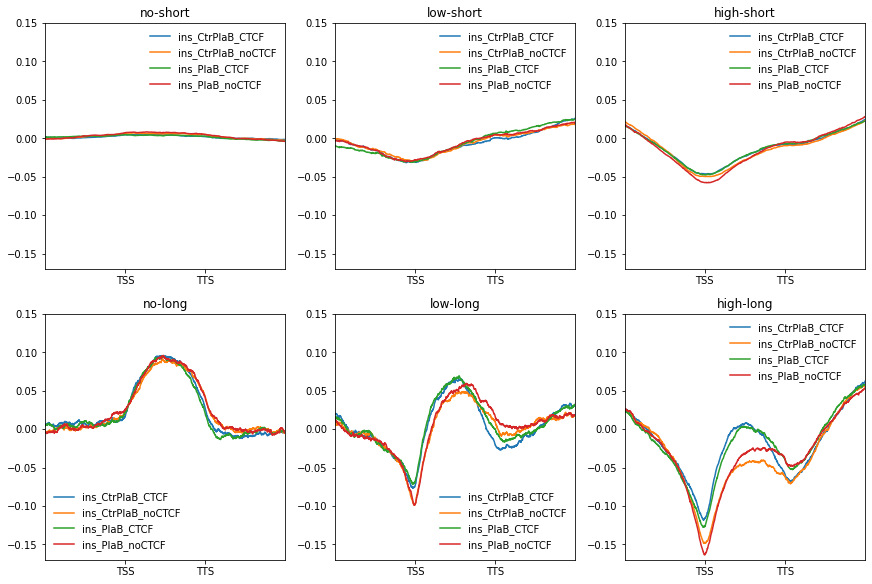

In [31]:
glens=("short","long")
gexps=("no","low","high")

mutant_keys = [k for k in key_features if k.startswith("ins") ]

fig = plt.figure(figsize=(12,8),constrained_layout=True)
gs = fig.add_gridspec(len(glens),len(gexps))

for i,glen in enumerate(glens):
    for j,gexp in enumerate(gexps):
        ax = fig.add_subplot(gs[i,j])
        for feature_name in mutant_keys:
            ins_profiles = profiles_dict[feature_name]
            ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
        ax.set_title(f"{gexp}-{glen}")
        ax.legend(frameon=False)
        ax.set_ylim(-0.17,.15)
        ax.set_xlim(0,3000)
        ax.set_xticks([1000,2000])
        ax.set_xticklabels(["TSS","TTS"])

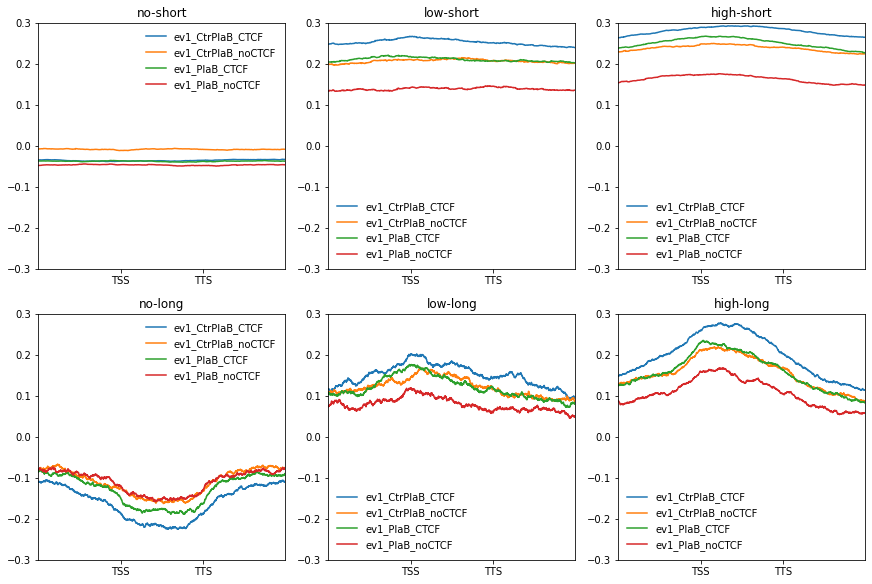

In [29]:
glens=("short","long")
gexps=("no","low","high")

mutant_keys = [k for k in key_features if k.startswith("ev1") ]

fig = plt.figure(figsize=(12,8),constrained_layout=True)
gs = fig.add_gridspec(len(glens),len(gexps))

for i,glen in enumerate(glens):
    for j,gexp in enumerate(gexps):
        ax = fig.add_subplot(gs[i,j])
        for feature_name in mutant_keys:
            ins_profiles = profiles_dict[feature_name]
            ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
        ax.set_title(f"{gexp}-{glen}")
        ax.legend(frameon=False)
        ax.set_ylim(-0.3,.3)
        ax.set_xlim(0,3000)
        ax.set_xticks([1000,2000])
        ax.set_xticklabels(["TSS","TTS"])

### Figure 3C itself ! comparing average insulation


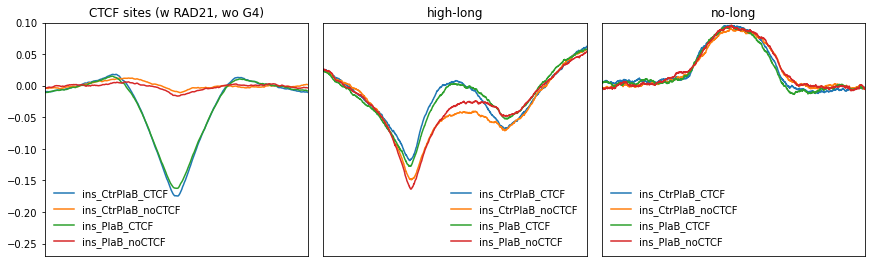

In [23]:
fig = plt.figure(figsize=(12,7),constrained_layout=True)
gs = fig.add_gridspec(2,3)
ins_ylim = (-0.27,.1)
rloop_ylim = (.7,4.5)

ins_keys_figure = key_features
# insulation profiles around CTCF-peaks
ax = fig.add_subplot(gs[0,0])
for feature_name in ins_keys_figure:
    ins_profile = CTCF_profiles_dict[feature_name]
    ax.plot(ins_profile,label=feature_name)
ax.set_title(f"CTCF sites (w RAD21, wo G4)")
ax.legend(frameon=False)
ax.set_ylim(ins_ylim)
ax.set_xlim(0,300)
ax.set_xticks([])
ax.set_xticklabels([])

# insulation profiles around genes ...
glen="long"
gexps=("high","no")
for j, gexp in enumerate(gexps):
    ax = fig.add_subplot(gs[0,j+1])
    for feature_name in ins_keys_figure:
        ins_profiles = profiles_dict[feature_name]
        ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
    ax.set_title(f"{gexp}-{glen}")
    ax.legend(frameon=False)
    ax.set_ylim(ins_ylim)
    ax.set_xlim(0,3000)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])




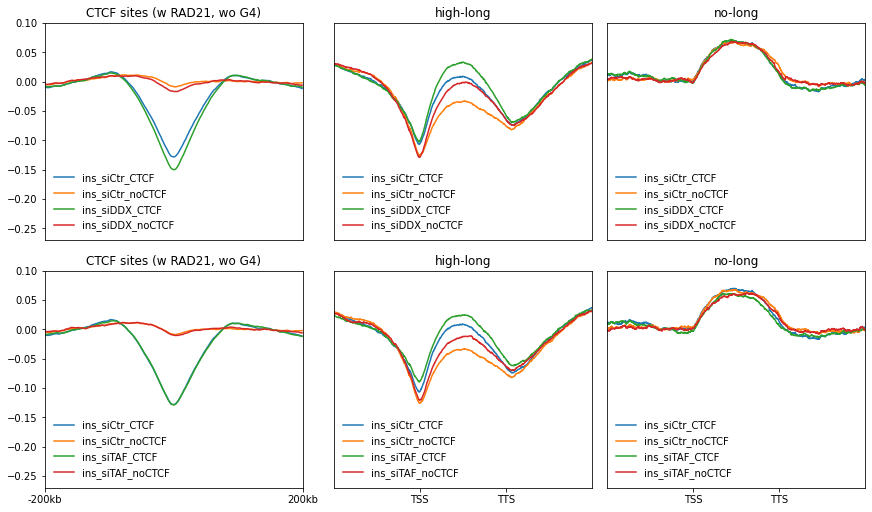

In [34]:
fig = plt.figure(figsize=(12,7),constrained_layout=True)
gs = fig.add_gridspec(2,3)
ins_ylim = (-0.27,.1)
rloop_ylim = (.7,4.5)

ins_keys_figure = [k for k in key_features if (k.startswith("ins_siCtr") or k.startswith("ins_siDDX")) ]
# insulation profiles around CTCF-peaks
ax = fig.add_subplot(gs[0,0])
for feature_name in ins_keys_figure:
    ins_profile = CTCF_profiles_dict[feature_name]
    ax.plot(ins_profile,label=feature_name)
ax.set_title(f"CTCF sites (w RAD21, wo G4)")
ax.legend(frameon=False)
ax.set_ylim(ins_ylim)
ax.set_xlim(0,300)
ax.set_xticks([])
ax.set_xticklabels([])

# insulation profiles around genes ...
glen="long"
gexps=("high","no")
for j, gexp in enumerate(gexps):
    ax = fig.add_subplot(gs[0,j+1])
    for feature_name in ins_keys_figure:
        ins_profiles = profiles_dict[feature_name]
        ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
    ax.set_title(f"{gexp}-{glen}")
    ax.legend(frameon=False)
    ax.set_ylim(ins_ylim)
    ax.set_xlim(0,3000)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])


ins_keys_figure = [k for k in key_features if (k.startswith("ins_siCtr") or k.startswith("ins_siTAF")) ]
# insulation profiles around CTCF-peaks
ax = fig.add_subplot(gs[1,0])
for feature_name in ins_keys_figure:
    ins_profile = CTCF_profiles_dict[feature_name]
    ax.plot(ins_profile,label=feature_name)
ax.set_title(f"CTCF sites (w RAD21, wo G4)")
ax.legend(frameon=False)
ax.set_ylim(ins_ylim)
ax.set_xlim(0,300)
ax.set_xticks([0,300])
ax.set_xticklabels(["-200kb","200kb"])

# insulation profiles around genes ...
glen="long"
gexps=("high","no")
for j, gexp in enumerate(gexps):
    ax = fig.add_subplot(gs[1,j+1])
    for feature_name in ins_keys_figure:
        ins_profiles = profiles_dict[feature_name]
        ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
    ax.set_title(f"{gexp}-{glen}")
    ax.legend(frameon=False)
    ax.set_ylim(ins_ylim)
    ax.set_xlim(0,3000)
    ax.set_xticks([1000,2000])
    ax.set_xticklabels(["TSS","TTS"])
    ax.set_yticks([])
    ax.set_yticklabels([])

plt.savefig("Figure6-siRNA-metaGene-insulation.pdf")    

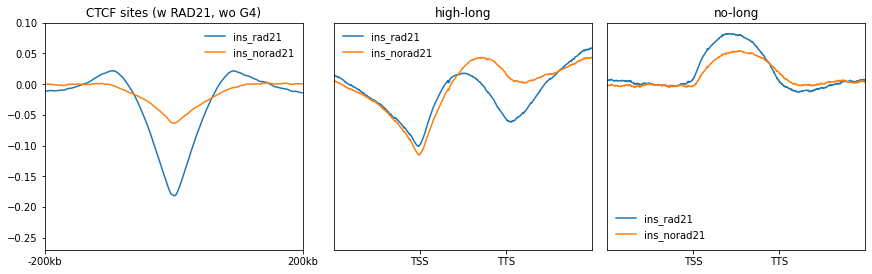

In [31]:
fig = plt.figure(figsize=(12,7),constrained_layout=True)
gs = fig.add_gridspec(2,3)
ins_ylim = (-0.27,.1)
rloop_ylim = (.7,4.5)

ins_keys_figure = ["ins_rad21","ins_norad21"]
# insulation profiles around CTCF-peaks
ax = fig.add_subplot(gs[1,0])
for feature_name in ins_keys_figure:
    ins_profile = CTCF_profiles_dict[feature_name]
    ax.plot(ins_profile,label=feature_name)
ax.set_title(f"CTCF sites (w RAD21, wo G4)")
ax.legend(frameon=False)
ax.set_ylim(ins_ylim)
ax.set_xlim(0,300)
ax.set_xticks([0,300])
ax.set_xticklabels(["-200kb","200kb"])

# insulation profiles around genes ...
glen="long"
gexps=("high","no")
for j, gexp in enumerate(gexps):
    ax = fig.add_subplot(gs[1,j+1])
    for feature_name in ins_keys_figure:
        ins_profiles = profiles_dict[feature_name]
        ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
    ax.set_title(f"{gexp}-{glen}")
    ax.legend(frameon=False)
    ax.set_ylim(ins_ylim)
    ax.set_xlim(0,3000)
    ax.set_xticks([1000,2000])
    ax.set_xticklabels(["TSS","TTS"])
    ax.set_yticks([])
    ax.set_yticklabels([])

plt.savefig("SuppFig3H-RAD21degron-metaGene-insulation-profile.pdf")